Created on Apr 4th 2025 by Anne Leroquais
The goal here is to check how cores are allocated on a mitgcm grid and which ones are only on land.
With the Exch2 package of MITgcm, these "land cores" can be ignored and thus reducing the number of cores needed for the simulation.

To do this, we need:
- the grid (to have the shape of the grid) (use notebook create_grid if you don't have it)
- the bathymetry (use notebook create_bathy if you don't have it)

In [15]:
import numpy as np
import os
import matplotlib.pyplot as plt 

from configs.config_object import ConfigObject

### Import data

In [5]:
config = ConfigObject('../configs/config.json')

grid_folder = config.paths.grid_folder_path
bathy_path = config.paths.bathy_path

In [6]:
x_grid = np.load(os.path.join(grid_folder, 'x_sg_grid.npy'))

In [7]:
with open(bathy_path, 'rb') as fid:
    bathy_bin_data = np.fromfile(fid, dtype='>f8')

### Reshape the array to get a grid like array

In [12]:
bathy_array = np.reshape(bathy_bin_data, (x_grid.shape[0],x_grid.shape[1]))

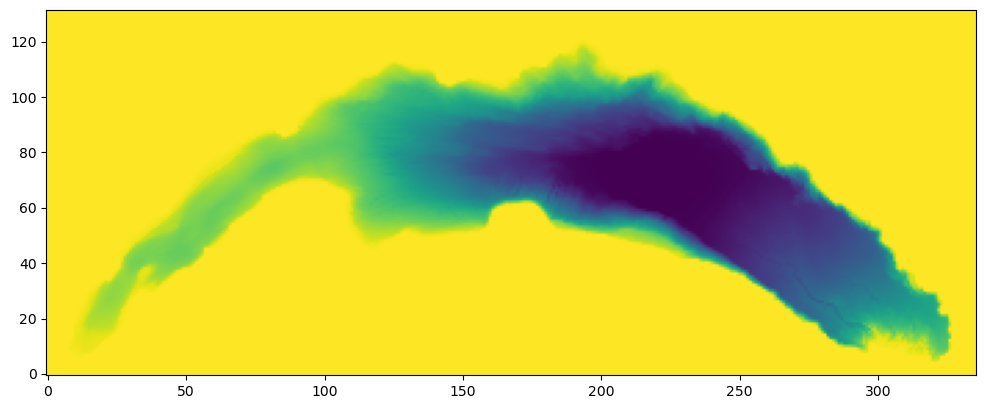

In [19]:
plt.figure(figsize=(12,7))
plt.imshow(bathy_array)
plt.gca().invert_yaxis()

### Choose the number of cores you want to use

In [113]:
Px = 12 #48
Py = 3 #12

sNx = bathy_array.shape[1] / Px
sNy = bathy_array.shape[0] / Py

print(f'sNx: {sNx}, sNy: {sNy}') # Should be integers

sNx: 28.0, sNy: 44.0


### Attribute numbers to these cores 

lower-left corner = 1. Then increases along x until the first line is completed. Continues from the left side of the second line and so on.

In [114]:
core_number_array = np.zeros(bathy_array.shape)
for i in range(Px):
    for j in range(Py):
        core_number_array[j*int(sNy) : (j+1)*int(sNy), i*int(sNx) : (i+1)*int(sNx)] = int(1 + i + j*int(Px))

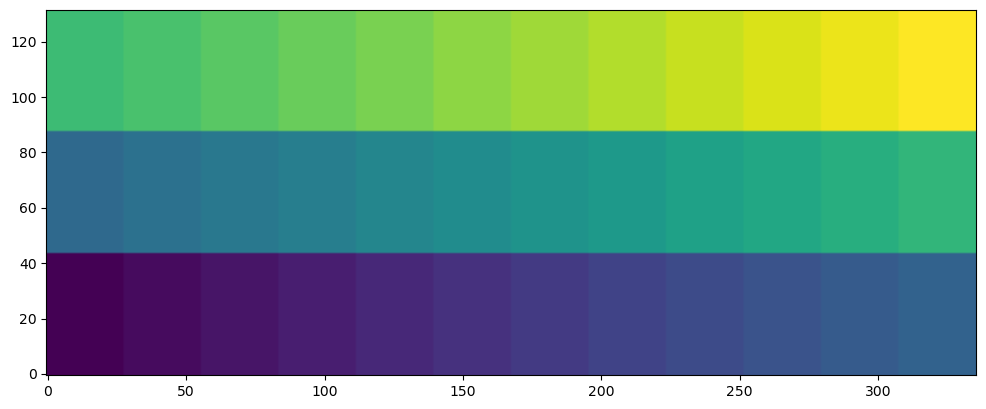

In [115]:
plt.figure(figsize=(12,7))
plt.imshow(core_number_array)
plt.gca().invert_yaxis()

### Compute mean depth for each rectangle allocated to a core

In [116]:
mean_bathy_array = np.zeros(bathy_array.shape)
for i in range(Px):
    for j in range(Py):
        mean_bathy_array[j*int(sNy) : (j+1)*int(sNy), i*int(sNx) : (i+1)*int(sNx)] = np.mean(bathy_array[j*int(sNy) : (j+1)*int(sNy), i*int(sNx) : (i+1)*int(sNx)])

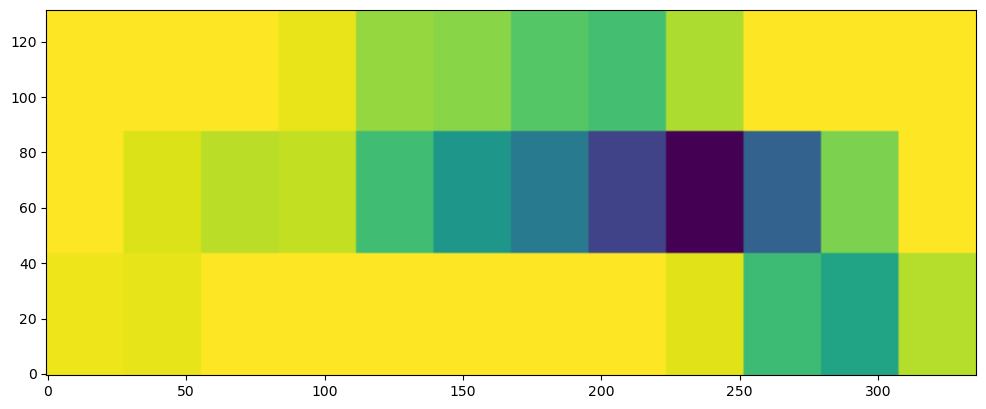

In [117]:
plt.figure(figsize=(12,7))
plt.imshow(mean_bathy_array)
plt.gca().invert_yaxis()

### Define cores that are only computing land

In 'create_bathy' notebook, all depths above -1m are considered as land and replaced by the value 2. If a core only covers land, the mean value of depth should then be equal to 2. Since some small decimals can appear, >= 2 is used instead of ==2.

In [118]:
mask_land_core = mean_bathy_array >= 2

In [119]:
land_cores = sorted(set(core_number_array[mask_land_core]))

In [120]:
land_cores

[np.float64(4.0),
 np.float64(5.0),
 np.float64(6.0),
 np.float64(7.0),
 np.float64(8.0),
 np.float64(24.0),
 np.float64(25.0),
 np.float64(26.0),
 np.float64(35.0),
 np.float64(36.0)]

In [121]:
len(land_cores)

10

In [122]:
print(f'Final number of cores needed: {Px*Py - len(land_cores)}')

Final number of cores needed: 26


# Save the list of land cores

to fill up  blankList(1:??)=   ??,..., ??, in  run_config/data.exch2

In [141]:
str_blank_list = (f'{len(land_cores)}\n'
                  f'blankList(1:{len(land_cores)})=   {",".join(map(str, map(int, land_cores)))},')
with open(os.path.join(grid_folder, f"land_cores_Px{Px}_Py{Py}.txt"), "w") as f:
    f.write(str_blank_list)